In [95]:
import optuna
from keras.optimizers import Adam, RMSprop
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [96]:
import importlib
from __imports__ import *
import data, LSTM_returns, optimization
importlib.reload(data)

<module 'data' from 'c:\\Users\\27904\\OneDrive\\桌面\\crypto\\AAA_Thursday1\\data\\__init__.py'>

In [97]:
sol = data.load_asset('SOLUSDT', sampling='1d')
sol = data.add_fear_and_greed(sol)
# Restrict data after 2022
sol = sol[sol.index >= '2020-01-01']
sol.head()

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,F&G,F&G category
Open time,,,,,,,,,,,
2020-08-11,2.8500,3.5208,2.8433,3.2985,1552384.78,4.939149e+06,13490,741770.79,2.370193e+06,84.0,Extreme Greed
2020-08-12,3.2985,3.9289,3.0800,3.7558,1737042.95,6.176154e+06,21118,889133.50,3.161944e+06,75.0,Greed
2020-08-13,3.7500,4.1387,3.5003,3.7300,1685759.24,6.446568e+06,22922,716358.46,2.755765e+06,75.0,Greed
2020-08-14,3.7207,3.7676,3.3210,3.4099,1474161.79,5.205834e+06,18581,578651.84,2.048897e+06,78.0,Extreme Greed
2020-08-15,3.4181,3.7400,3.1500,3.1730,1070233.20,3.658006e+06,13903,439623.97,1.510473e+06,79.0,Extreme Greed


In [98]:
sol.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume',
       'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume', 'F&G', 'F&G category'],
      dtype='object')

In [99]:
import numpy as np
import pandas as pd
import ta  # pip install ta

def compute_slope(series):
    y = series.values
    x = np.arange(len(y))
    if len(y) == 0:
        return np.nan
    return np.polyfit(x, y, 1)[0]

def add_technical_features(df, look_back=14):
    df = df.copy()  # avoid modifying original

    # Return: Daily log return
    df['Return'] = np.log(df['Close'] / df['Close'].shift(1))

    # Risk: Rolling std dev (volatility)
    df['Risk'] = df['Return'].rolling(window=look_back).std()

    # RSI
    df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'], window=look_back).rsi()

    # ADX
    df['ADX'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=look_back).adx()

    # Momentum
    df['MOM'] = df['Close'] - df['Close'].shift(look_back)

    # High-low spread
    df['HL'] = df['High'] - df['Low']

    # High-open & low-open
    df['HO'] = df['High'] - df['Open']
    df['LO'] = df['Low'] - df['Open']

    # Buy pressure ratio
    df['buy_pressure_ratio'] = df['Taker buy quote asset volume'] / df['Quote asset volume']

    # Trades per volume
    df['trades_per_volume'] = df['Number of trades'] / df['Quote asset volume']

    # Rolling slope
    df['slope'] = df['Close'].rolling(window=look_back).apply(compute_slope, raw=False)

    # Drop NaN from lookback window
    df = df.dropna()

    # Drop unnecessary columns
    cols_to_drop = [
        'Open', 'High', 'Low', 'Quote asset volume',
        'Number of trades', 'Taker buy base asset volume',
        'Taker buy quote asset volume', 'F&G'
    ]
    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

    return df


In [100]:
sol = add_technical_features(sol)
sol.head()

,Close,Volume,F&G category,Return,Risk,RSI,ADX,MOM,HL,HO,LO,buy_pressure_ratio,trades_per_volume,slope
Open time,,,,,,,,,,,,,,
2020-08-25,3.2500,1149187.37,Greed,-0.027466,0.085476,49.797443,0.0,-0.0485,0.3653,0.0248,-0.3405,0.414953,0.003919,-0.034897
2020-08-26,3.5684,2290030.56,Extreme Greed,0.093462,0.081659,57.152129,0.0,-0.1874,0.6190,0.5423,-0.0767,0.548917,0.002973,-0.010371
2020-08-27,3.4501,2412974.80,Greed,-0.033714,0.082054,53.987465,0.0,-0.2799,0.6141,0.3018,-0.3123,0.482751,0.003006,0.010749
2020-08-28,4.0063,2581936.84,Greed,0.149465,0.087879,64.062997,0.0,0.5964,0.8588,0.8588,0.0000,0.548365,0.003016,0.038438
2020-08-29,3.9535,1342844.20,Extreme Greed,-0.013267,0.084938,62.660274,0.0,0.7805,0.3373,0.1051,-0.2322,0.440181,0.003651,0.054187


In [101]:
sol.columns

Index(['Close', 'Volume', 'F&G category', 'Return', 'Risk', 'RSI', 'ADX',
       'MOM', 'HL', 'HO', 'LO', 'buy_pressure_ratio', 'trades_per_volume',
       'slope'],
      dtype='object')

In [102]:
def prep_data(df, sequence_length=60, test_size=0.2):
    # 1) include 'Close' since that's what we'll predict
    features = [
        'Close',      # ← our prediction target
        'Volume', 'F&G category', 'Return', 'Risk', 'RSI', 'ADX',
        'MOM', 'HL', 'HO', 'LO',
        'buy_pressure_ratio', 'trades_per_volume', 'slope'
    ]
    
    # 2) split numeric vs categorical
    num_feats = [f for f in features if f != 'F&G category']
    df_num = df[num_feats]
    df_cat = pd.get_dummies(df['F&G category'], prefix='F_G')
    
    # 3) combine & scale
    df_all = pd.concat([df_num, df_cat], axis=1).dropna()
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(df_all.values)
    feature_names = df_all.columns.tolist()
    
    # 4) build sequences for time-series
    target_idx = feature_names.index('Close')
    X, y = [], []
    for i in range(sequence_length, len(data_scaled)):
        X.append(data_scaled[i-sequence_length:i])
        # y is the scaled Close price at time i (next day)
        y.append(data_scaled[i, target_idx])
    X, y = np.array(X), np.array(y)
    
    # 5) train/test split (preserving time order)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=False
    )
    return (X_train, X_test, y_train, y_test), scaler



In [103]:
# 2. Build LSTM model given an Optuna trial
def create_model(trial, input_shape):
    model = Sequential()
    # choose #layers
    n_layers = trial.suggest_int('n_layers', 1, 3)
    for i in range(n_layers):
        # units per layer
        units = trial.suggest_int(f'n_units_l{i}', 32, 256, step=32)
        # return sequences except for last LSTM
        ret_seq = (i < n_layers - 1)
        if i == 0:
            model.add(LSTM(units, return_sequences=ret_seq, input_shape=input_shape))
        else:
            model.add(LSTM(units, return_sequences=ret_seq))
        # dropout
        d = trial.suggest_float(f'dropout_l{i}', 0.0, 0.5, step=0.1)
        if d > 0:
            model.add(Dropout(d))
    model.add(Dense(1, activation='linear'))
    
    # optimizer & LR
    lr = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    opt_name = trial.suggest_categorical('optimizer', ['Adam','RMSprop'])
    optimizer = Adam(lr) if opt_name=='Adam' else RMSprop(lr)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# 3. Optuna objective
def objective(trial):
    (X_train, X_val, y_train, y_val), _ = prep_data(sol, sequence_length=SEQUENCE_LENGTH, test_size=TEST_SIZE)
    
    model = create_model(trial, input_shape=X_train.shape[1:])
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=MAX_EPOCHS,
        batch_size=trial.suggest_int('batch_size', 32, 256, step=32),
        callbacks=[es],
        verbose=0
    )
    return min(history.history['val_loss'])


[I 2025-04-30 16:27:43,522] A new study created in memory with name: no-name-552ca359-67b2-4258-b895-ebfc31990918
c:\Users\27904\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-04-30 16:27:50,418] Trial 0 finished with value: 0.00661363685503602 and parameters: {'n_layers': 1, 'n_units_l0': 32, 'dropout_l0': 0.0, 'learning_rate': 0.00012817998049742248, 'optimizer': 'RMSprop', 'batch_size': 96}. Best is trial 0 with value: 0.00661363685503602.
c:\Users\27904\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead

Best validation MSE: 0.0012498663272708654
  n_layers: 1
  n_units_l0: 160
  dropout_l0: 0.0
  learning_rate: 0.0007280355873484089
  optimizer: Adam
  batch_size: 32
Epoch 1/50


c:\Users\27904\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0215 - val_loss: 0.0045
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.5434e-04 - val_loss: 0.0026
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.3368e-04 - val_loss: 0.0023
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.6568e-04 - val_loss: 0.0024
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.9298e-04 - val_loss: 0.0033
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.5058e-04 - val_loss: 0.0022
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.1091e-04 - val_loss: 0.0017
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.7376e-04 - val_loss: 0.0015
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.2675e-04 - val_loss: 0.0015
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.6638e-04 - val_loss: 0.0033
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.1280e-04 - val_loss: 0.0022
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━

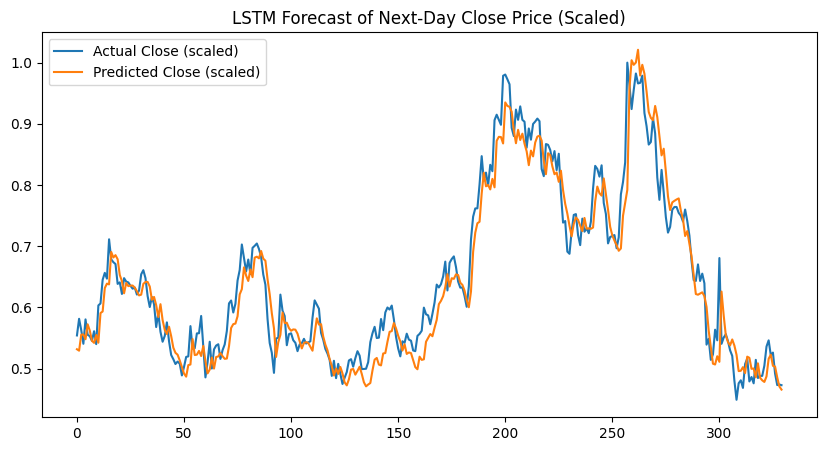

In [104]:
from tensorflow.keras.callbacks import EarlyStopping

SEQUENCE_LENGTH = 30
TEST_SIZE       = 0.2
N_TRIALS        = 50
MAX_EPOCHS      = 50

# 1. Run Optuna hyperparameter search
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=N_TRIALS)

print("Best validation MSE:", study.best_value)
for k, v in study.best_trial.params.items():
    print(f"  {k}: {v}")

# 2. Retrain best model on full train+val
(X_train, X_val, y_train, y_val), scaler = prep_data(
    sol,
    sequence_length=SEQUENCE_LENGTH,
    test_size=TEST_SIZE
)
best = study.best_trial
best_model = create_model(best, input_shape=X_train.shape[1:])
best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=MAX_EPOCHS,
    batch_size=best.params['batch_size'],
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

# 3. Plot predictions vs actual Close (scaled)
preds = best_model.predict(X_val).flatten()
plt.figure(figsize=(10,5))
plt.plot(y_val, label='Actual Close (scaled)')
plt.plot(preds, label='Predicted Close (scaled)')
plt.legend()
plt.title("LSTM Forecast of Next-Day Close Price (Scaled)")
plt.show()

In [114]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 1) Rebuild the df_all feature names exactly as in prep_data()
num_feats = [
    'Close', 'Volume', 'Return', 'Risk', 'RSI', 'ADX',
    'MOM', 'HL', 'HO', 'LO',
    'buy_pressure_ratio', 'trades_per_volume', 'slope'
]
df_num = sol[num_feats]
df_cat = pd.get_dummies(sol['F&G category'], prefix='F_G')
df_all = pd.concat([df_num, df_cat], axis=1).dropna()
feature_names = df_all.columns.tolist()

# 2) Find the position of “Close”
close_idx = feature_names.index('Close')

# 3) Grab mean/scale from your StandardScaler
close_mean  = scaler.mean_[close_idx]
close_scale = scaler.scale_[close_idx]

# 4) Invert the scaling for your arrays y_val and preds
y_val_unscaled  = y_val * close_scale + close_mean
preds_unscaled  = preds * close_scale + close_mean

# 5) Compute dollar‐errors
mse_dollars  = mean_squared_error(y_val_unscaled, preds_unscaled)
rmse_dollars = np.sqrt(mse_dollars)
mae_dollars  = mean_absolute_error(y_val_unscaled, preds_unscaled)

# 6) Compute percentage errors
mean_price = y_val_unscaled.mean()
pct_rmse   = rmse_dollars / mean_price * 100
pct_mae    = mae_dollars  / mean_price * 100

# 7) Print results
print(f"Unscaled →  MSE: {mse_dollars:.4f}, RMSE: {rmse_dollars:.4f}, MAE: {mae_dollars:.4f}")
print(f"Pct RMSE: {pct_rmse:.1f}%, Pct MAE: {pct_mae:.1f}%")



Unscaled →  MSE: 34488610809.7091, RMSE: 185711.0950, MAE: 141215.8873
Pct RMSE: 4.1%, Pct MAE: 3.1%


In [113]:
# assume y_val_unscaled is your true next‐day Close array

y_true = y_val_unscaled
y_base_pred  = y_true[:-1]   # use day t to predict t+1  
y_true_shift = y_true[1:]    # actual for days 1…T

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse_base = np.sqrt(mean_squared_error(y_true_shift, y_base_pred))
mae_base  = mean_absolute_error(y_true_shift, y_base_pred)
pct_rmse_base = rmse_base / y_true_shift.mean() * 100
pct_mae_base  = mae_base  / y_true_shift.mean() * 100

print(f"Baseline → RMSE: {rmse_base:.4f}, MAE: {mae_base:.4f}")
print(f"Pct RMSE: {pct_rmse_base:.1f}%, Pct MAE: {pct_mae_base:.1f}%")

Baseline → RMSE: 245260.4679, MAE: 179550.9338
Pct RMSE: 5.4%, Pct MAE: 3.9%


Epoch 1/50


c:\Users\27904\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 0.1092 - val_loss: 0.0065
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0228 - val_loss: 0.0080
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 0.0097 - val_loss: 0.0047
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.0095 - val_loss: 0.0046
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0065 - val_loss: 0.0039
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0057 - val_loss: 0.0146
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0045 - val_loss: 0.0140
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 0.0037 - val_loss: 0.0120
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.0045 - val_loss: 0.0080
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0038 - val_loss: 0.0066
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0034 

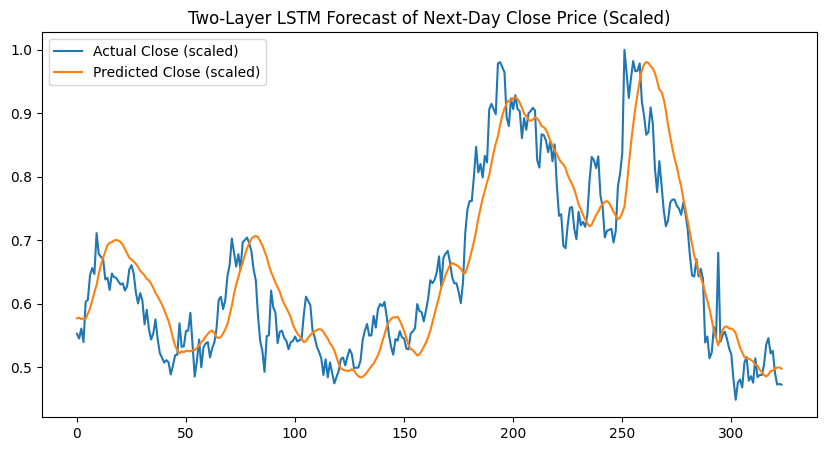

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping



# ——— Hyperparameters ———
SEQUENCE_LENGTH = 60
TEST_SIZE       = 0.2
MAX_EPOCHS      = 50
BATCH_SIZE      = 96

# Layer 1
UNITS_L1        = 160
DROPOUT_L1      = 0.1

# Layer 2
UNITS_L2        = 80
DROPOUT_L2      = 0.1

LEARNING_RATE   = 0.0006944933875842594

# 1) Prepare the data
(X_train, X_val, y_train, y_val), scaler = prep_data(
    sol,
    sequence_length=SEQUENCE_LENGTH,
    test_size=TEST_SIZE
)

# 2) Build a two‐layer LSTM
model = Sequential()
# first LSTM returns full sequences for the next layer
model.add(LSTM(UNITS_L1, return_sequences=True, input_shape=X_train.shape[1:]))
model.add(Dropout(DROPOUT_L1))

# second LSTM collapses to a single vector
model.add(LSTM(UNITS_L2, return_sequences=False))
model.add(Dropout(DROPOUT_L2))

# final regression output
model.add(Dense(1, activation='linear'))

model.compile(
    optimizer=RMSprop(learning_rate=LEARNING_RATE),
    loss='mean_squared_error'
)

# 3) Train with early stopping
EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es],
    verbose=1
)

# 4) Plot scaled predictions vs actual
preds = model.predict(X_val).flatten()
plt.figure(figsize=(10, 5))
plt.plot(y_val,  label='Actual Close (scaled)')
plt.plot(preds, label='Predicted Close (scaled)')
plt.legend()
plt.title("Two‐Layer LSTM Forecast of Next‐Day Close Price (Scaled)")
plt.show()


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.1012 - val_loss: 0.0098
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0393 - val_loss: 0.0078
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0354 - val_loss: 0.0054
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0294 - val_loss: 0.0033
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0270 - val_loss: 0.0057
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0286 - val_loss: 0.0030
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0240 - val_loss: 0.0051
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0222 - val_loss: 0.0038
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0204 - val_loss: 0.0031
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0192 - val_loss: 0.0035
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0184 - val_loss: 0.0031
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0

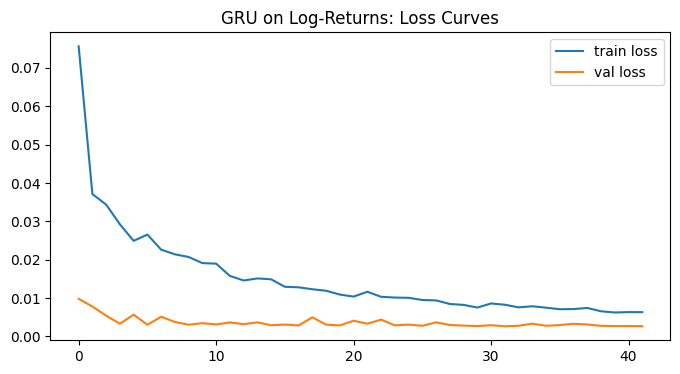

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


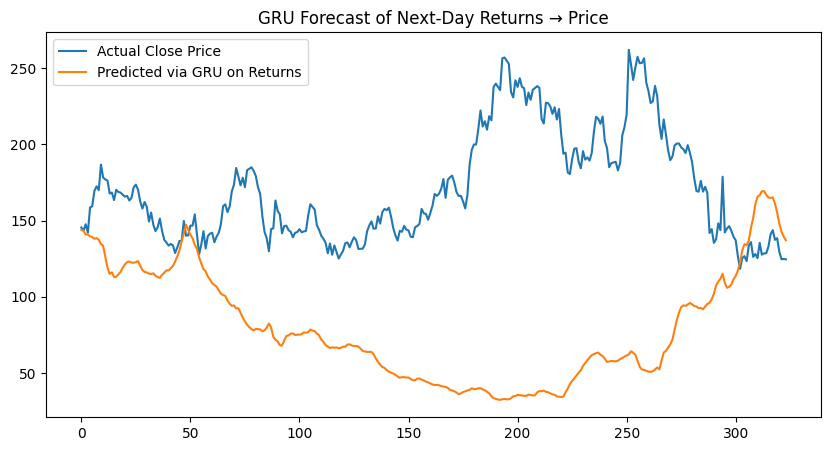

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# --- 1) Prepare log-return data ---
# assume `sol` is your DataFrame with a 'Close' column and 'F&G category'
df = sol.copy().dropna()
df['LogReturn'] = np.log(df['Close']).diff().fillna(0)

# numeric features
num_feats = [
    'Volume', 'Return', 'Risk', 'RSI', 'ADX',
    'MOM', 'HL', 'HO', 'LO',
    'buy_pressure_ratio', 'trades_per_volume', 'slope'
]
df_num = df[num_feats]
# one-hot F&G category
df_cat = pd.get_dummies(df['F&G category'], prefix='F_G')
# full feature matrix
df_all = pd.concat([df_num, df_cat], axis=1)

# scale features to zero mean/unit var
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_all.values)

# targets = next-day log-return
y_all = df['LogReturn'].values

# build sequences
SEQ_LEN = 60
X, y = [], []
for i in range(SEQ_LEN, len(data_scaled)):
    X.append(data_scaled[i-SEQ_LEN:i])
    y.append(y_all[i])
X = np.array(X)
y = np.array(y)

# train/val split (no shuffle)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# --- 2) Build a simple GRU model for returns ---
model = Sequential([
    Input(shape=X_train.shape[1:]),
    GRU(128, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='linear')
])
model.compile(optimizer=Adam(1e-3), loss='mse')

# --- 3) Train with early stopping ---
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=128,
    callbacks=[es],
    verbose=1
)

# plot training vs val loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title("GRU on Log-Returns: Loss Curves")
plt.show()

# --- 4) Predict and reconstruct price trajectory ---
preds = model.predict(X_val).flatten()
# true prices for alignment
prices_true = df['Close'].iloc[-len(preds):].values
# reconstruct via cumulative sum of log returns
prices_pred = prices_true[0] * np.exp(np.cumsum(preds))

plt.figure(figsize=(10,5))
plt.plot(prices_true, label='Actual Close Price')
plt.plot(prices_pred, label='Predicted via GRU on Returns')
plt.legend()
plt.title("GRU Forecast of Next‐Day Returns → Price")
plt.show()




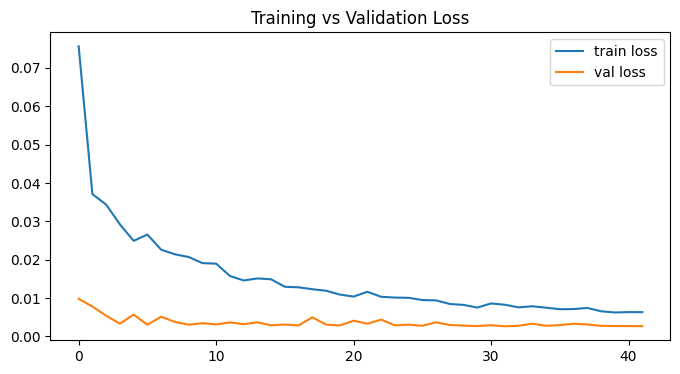

In [109]:
# after fitting:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()
